# Training while monitoring observables

As seen in the first tutorial that went through reconstructing the wavefunction describing the TFIM with 10 sites at its critical point, the user can evaluate the training in real time with *MetricEvaluator* and custom functions. What is most likely more impactful in many cases is to calculate an observable, like the energy, during the training process. This is slightly more computationally involved than using the *MetricEvaluator* to evaluate functions because observables require that samples be drawn from the RBM. 

Luckily, qucumber also has a module very similar to the *MetricEvaluator*, but for observables. This is called the *ObservableEvaluator*. The following implements the *ObservableEvaluator* to calculate the energy during the training on the TFIM data in the first tutorial. We will use the same hyperparameters as before.

Recall that quantum_ising_chain.py contains the *TFIMChainEnergy* class that inherits from the *Observable* module. The exact ground-state energy is -1.2381.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWavefunction
from qucumber.callbacks import ObservableEvaluator

import qucumber.utils.data as data

import quantum_ising_chain
from quantum_ising_chain import TFIMChainEnergy

train_data = np.loadtxt("../Tutorial1_TrainPosRealWavefunction/tfim1d_data.txt")

nv = train_data.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv, num_hidden=nh)

epochs = 1000
pbs    = 100 # pos_batch_size
nbs    = 200 # neg_batch_size
lr     = 0.01
k      = 10

log_every = 100

h = 1
num_samples = 10000
burn_in     = 100
steps       = 100

tfim_energy = TFIMChainEnergy(h)

Now, the *ObservableEvaluator* can be called. The *ObservableEvaluator* requires the following arguments.

1. **log_every**: the frequency of the training evaluators being calculated is controlled by the *log_every* argument (e.g. *log_every* = 200 means that the *MetricEvaluator* will update the user every 200 epochs)
2. A list of *Observable* objects you would like to reference to evaluate the training (arguments required for generating samples to calculate the observables are keyword arguments placed after the list)

The following additional arguments are needed to calculate the statistics on the generated samples during training (these are the arguments of the *statistics* function in the *Observable* module, minus the *nn_state* argument; this gets passed in as an argument to *fit). 

- **num_samples**: the number of samples to generate internally
- **num_chains**: the number of Markov chains to run in parallel (default = 0)
- **burn_in**: the number of Gibbs steps to perform before recording any samples (default = 1000)
- **steps**: the number of Gibbs steps to perform between each sample (default = 1)

The training evaluators can be printed out via the *verbose=True* statement.

In [2]:
callbacks = [
    ObservableEvaluator(log_every, [tfim_energy], verbose=True, num_samples=num_samples, 
                        burn_in=burn_in, steps=steps)
]

nn_state.fit(train_data, epochs=epochs, pos_batch_size=pbs, neg_batch_size=nbs, lr=lr, k=k, callbacks=callbacks)

Epoch: 100
  TFIMChainEnergy:
    mean: -1.195911	variance: 0.023170	std_error: 0.001522
Epoch: 200
  TFIMChainEnergy:
    mean: -1.218775	variance: 0.012323	std_error: 0.001110
Epoch: 300
  TFIMChainEnergy:
    mean: -1.221125	variance: 0.008264	std_error: 0.000909
Epoch: 400
  TFIMChainEnergy:
    mean: -1.228525	variance: 0.005946	std_error: 0.000771
Epoch: 500
  TFIMChainEnergy:
    mean: -1.230197	variance: 0.004708	std_error: 0.000686
Epoch: 600
  TFIMChainEnergy:
    mean: -1.231181	variance: 0.004000	std_error: 0.000632
Epoch: 700
  TFIMChainEnergy:
    mean: -1.233475	variance: 0.003267	std_error: 0.000572
Epoch: 800
  TFIMChainEnergy:
    mean: -1.233604	variance: 0.002877	std_error: 0.000536
Epoch: 900
  TFIMChainEnergy:
    mean: -1.234921	variance: 0.002334	std_error: 0.000483
Epoch: 1000
  TFIMChainEnergy:
    mean: -1.235251	variance: 0.002003	std_error: 0.000448


The *callbacks* list returns a list of dictionaries.

In [3]:
print (callbacks[0].TFIMChainEnergy)

[{'mean': -1.1959110078172681, 'variance': 0.023170129463663622, 'std_error': 0.0015221737569562689}, {'mean': -1.218774695926404, 'variance': 0.012322693665323603, 'std_error': 0.001110076288609193}, {'mean': -1.221125154291777, 'variance': 0.008264004005875536, 'std_error': 0.000909065674518378}, {'mean': -1.228525134554893, 'variance': 0.005946346302249876, 'std_error': 0.0007711255606092873}, {'mean': -1.2301965178416538, 'variance': 0.00470787260368095, 'std_error': 0.0006861393884394737}, {'mean': -1.2311806605584763, 'variance': 0.003999839891613989, 'std_error': 0.0006324428742277036}, {'mean': -1.2334751831112076, 'variance': 0.003267025603832779, 'std_error': 0.0005715790062478484}, {'mean': -1.2336041208609247, 'variance': 0.0028769780648046596, 'std_error': 0.0005363746885158414}, {'mean': -1.2349207061361103, 'variance': 0.0023339314515264534, 'std_error': 0.000483107798687462}, {'mean': -1.2352506684937996, 'variance': 0.0020028007322839994, 'std_error': 0.000447526617340

The mean, standard error and the variance at each epoch can be accessed as follows.

In [4]:
energies = [i['mean'] for i in callbacks[0].TFIMChainEnergy]
errors   = [i['std_error'] for i in callbacks[0].TFIMChainEnergy]
variance = [i['variance'] for i in callbacks[0].TFIMChainEnergy]

A plot of the energy as a function of the training cycle is presented below.

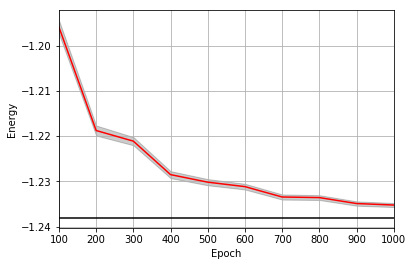

In [6]:
epoch = np.arange(log_every, epochs+1, log_every)

E0 = -1.2381

ax = plt.axes()
ax.plot(epoch, np.array(energies), color='red')
ax.set_xlim(log_every, epochs)
ax.axhline(E0, color='black')
ax.fill_between(epoch, np.array(energies)-np.array(errors), np.array(energies)+np.array(errors), alpha=0.2, color='black')
ax.set_xlabel("Epoch")
ax.set_ylabel("Energy")
ax.grid()